# Assess Huntington's disease progression from PET/MR images

In [1]:
import itertools
import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns

import hd_classifier

## Inflammation assesment using PBR scans

### Participants information

In [2]:
participants_df = pd.read_csv('data/participants.tsv', delimiter='\t')
participants_df

,subject_id,group,neurological_score,intracraneal_volume
0,sub-control01,control,None,1.720386e+06
1,sub-control02,control,None,1.294547e+06
2,sub-control03,control,None,1.719868e+06
3,sub-control04,control,None,1.593478e+06
4,sub-control05,control,None,1.502192e+06
5,sub-control06,control,None,1.498275e+06
6,sub-patient01,pre-HD,12,1.691144e+06
7,sub-patient02,HD,11,1.620931e+06
8,sub-patient03,HD,11,1.623385e+06
9,sub-patient04,HD,6,1.311834e+06


We also set some colors for the groups.

In [3]:
subject_colors = {'HD': 'r', 'pre-HD': 'g', 'control': 'b'}

### Principal component analysis

We extract all voxels for each subject and region directly from the nifti images and the masks generated from Freesurfer.

We use principal component analysis to transform each subject into the vector space spanned by the eigenvectors of the covariance matrix. The plots show the components along each axis in this subspace for each patient. The axis are ordered according to the value of the eigenvectors.

We choose a few statistical quantities to describe each region

In [4]:
q_1 = lambda x: np.percentile(x, q=25)
q_3 = lambda x: np.percentile(x, q=75)

features = {'value' : {'min' : np.min, 'max' : np.max, 'mean' : np.mean, 
                       'q_1' : q_1, 'median' : np.median, 'q_3' : q_3 }} 

Extract the voxel data, calculate statistical features for all regions and subjects, and put them into a `pd.DataFrame`.

In [5]:
path_to_tracer_data = './data/func'
items = os.listdir(path_to_tracer_data)

subjects = hd_classifier.make_subjects(items, path_to_tracer_data)
image_filter = '^r.*\.lin_T1_orientOK_skullstripped_norm_sm6mm.nii'

masked_region_df_pbr, masked_region_features_pbr = hd_classifier.extract_features(subjects, features, image_filter)
masked_region_features_pbr

value                                                    \
                    min                                     max             
region          caudate  pallidum   putamen  thalamus   caudate  pallidum   
subject_id                                                                  
sub-control01 -0.357949 -0.986629 -0.479293  0.157071 -0.378503 -0.939962   
sub-control02  2.350970 -0.919913  0.236221  1.654546  0.101800 -0.405937   
sub-control03  1.354500 -0.874280 -1.572039  1.180632 -0.565642 -0.791115   
sub-control04  0.054450 -1.087225 -0.097938 -1.097358 -1.368482 -1.673687   
sub-control05 -1.019404 -0.357744 -0.204904 -1.233020  0.044988 -0.649875   
sub-control06 -0.750866 -1.328470 -1.709454 -1.707702 -2.440500 -0.773118   
sub-patient01  0.681762 -0.290246 -0.430546  0.964200 -0.075971 -0.586998   
sub-patient02 -0.160849 -0.488603  0.797064  0.576606 -0.392622 -0.166097   
sub-patient03 -0.367979  1.121198 -1.202382  0.091982  0.673253  0.317037   
sub-patient04 -0.631583  0.763923  1.004552 -1.187244  1.004082  0.850643   
sub-patient05 -0.660727  1.394849  0.714170  0.121850  1.047222  1.095686   
sub-patient06 -0.609619  1.270318  0.370503  0.349612  0.561016  1.379259   
sub-patient07  1.074556  0.771186  1.157279  0.498919  1.070641  1.650544   
sub-patient08 -0.957262  1.011637  1.416767 -0.370096  0.718718  0.693619   

                                                         ...               \
                                       mean              ...          q_1   
region          putamen  thalamus   caudate  pallidum    ...      putamen   
subject_id                                               ...                
sub-control01 -0.736445 -1.532574 -1.150603 -0.761989    ...    -1.180815   
sub-control02 -0.620280 -0.493392  0.430512 -0.759552    ...    -1.499511   
sub-control03 -1.048844 -0.487197  0.489527 -0.734835    ...    -0.603145   
sub-control04 -1.693252 -2.011960  0.143684 -1.160719    ...    -0.946822   
sub-control05 -0.792171  0.086470 -0.759269 -0.703325    ...    -0.489154   
sub-control06 -0.312556  0.873162 -2.181602 -1.147991    ...    -1.293506   
sub-patient01 -0.694732 -0.033583  0.334657 -0.616984    ...    -0.233491   
sub-patient02 -0.091567 -0.231409 -0.266129 -0.620940    ...     0.696320   
sub-patient03  0.178251 -0.412254 -0.158297  0.808728    ...     0.496184   
sub-patient04  1.026635  0.864310 -0.993388  0.917083    ...     0.705017   
sub-patient05  1.134615  0.688741  0.836467  1.494141    ...     1.012394   
sub-patient06  1.328593  1.626617  0.592886  1.103613    ...     0.986254   
sub-patient07  1.328101  1.121272  1.177436  1.247389    ...     0.908398   
sub-patient08  0.993653 -0.058205  1.504118  0.935381    ...     1.441877   

                                                                           \
                           median                                     q_3   
region         thalamus   caudate  pallidum   putamen  thalamus   caudate   
subject_id                                                                  
sub-control01 -0.090717 -0.914007 -0.784279 -1.294768 -0.466123 -1.102167   
sub-control02  0.485232  0.359119 -0.739018 -1.459175  0.148270 -0.357245   
sub-control03  0.272596  0.305083 -0.722195 -0.703113  0.235514  0.032952   
sub-control04 -0.819745  0.340724 -1.115710 -1.087211 -1.351511 -0.024543   
sub-control05 -0.847543 -0.927993 -0.737042 -0.650332 -0.767099 -0.389207   
sub-control06 -2.735069 -2.068964 -1.111939 -0.780123 -2.311989 -2.287850   
sub-patient01  0.680017  0.309945 -0.677452 -0.312480  0.743108 -0.056386   
sub-patient02 -0.142947 -0.303515 -0.641768  0.607843 -0.108955  0.012291   
sub-patient03  0.760108 -0.243706  0.898787  0.510219  0.698865  0.130179   
sub-patient04 -0.305956 -1.179329  0.861236  0.902033 -0.203721 -0.608125   
sub-patient05 -0.010918  0.832995  1.500747  1.129411  0.080089  1.106190   
sub-patient06  0.781821  0.893214  0.995257  0.886581  1.022429  0.852077   
sub-patient0

Calculate the principal component rotated basis

In [6]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
pca.fit(masked_region_features_pbr.as_matrix())

rotated_subjects_pbr = pca.fit_transform(masked_region_features_pbr.as_matrix())

# Note that we flip the axis of the first feature, assigned randomly by the algorithm, so increases from
# controls to patients.
pca_results = pd.DataFrame(dict(first_feature=-rotated_subjects_pbr[:,0],
                         second_feature=rotated_subjects_pbr[:,1],
                         subject_id = masked_region_features_pbr.index.values))

pca_results.sort_values(by='first_feature', inplace=True)
pca_results.reset_index(drop=True, inplace=True)

pca_results = pca_results.merge(participants_df[['subject_id', 'group']], on='subject_id')
pca_results

,first_feature,second_feature,subject_id,group
0,-1.761875,-1.815264,sub-control06,control
1,-1.282251,0.437398,sub-control04,control
2,-1.041683,0.080606,sub-control01,control
3,-0.750422,-0.688063,sub-control05,control
4,-0.528717,1.838545,sub-control02,control
5,-0.514645,1.373600,sub-control03,control
6,-0.117564,1.128435,sub-patient01,pre-HD
7,-0.113103,-0.093377,sub-patient02,HD
8,0.501968,-1.643643,sub-patient04,HD
9,0.512946,-0.301880,sub-patient03,HD


In [7]:
# Make a list with all the name features as region_feature to label the plots. E.g. thalamus_min
pca_features = [(item[1] + ' ' + item[0]).title() 
                for item in itertools.product(list(masked_region_features_pbr.columns.levels[1]),                         
                                              list(masked_region_features_pbr.columns.levels[2]))]

# Get the coefficient of each feature for the first 3 principal axis
transformed_features = sorted(zip(pca_features, *pca.components_[0:4]), key=lambda t: t[0])

Let's order the data according to the score in the plot above.

In [8]:
masked_region_df_pbr['subject_id'] = pd.Categorical(masked_region_df_pbr['subject_id'], pca_results.subject_id)

Just a couple of features classify inflammation in patients vs controls. Even only one feature, classifies the subjects in at least two groups

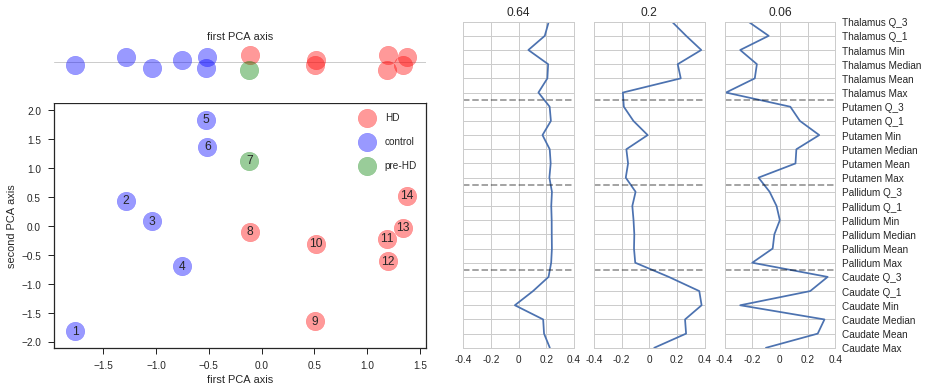

In [9]:
# Some values overlap in the final plot, so we add some ad-hoc jittering
jitters = np.zeros(14)
jitters[0] = -.01
jitters[1] = .02
jitters[2] = -.02
jitters[3] = .01
jitters[4] = -.02
jitters[5] = .02
jitters[6] = -.03
jitters[7] = .03
jitters[8] = -.01
jitters[9] = .01
jitters[10] = -.03
jitters[11] = .03
jitters[12] = -.01
jitters[13] = .02

joined = pca_results.join(pd.DataFrame(dict(jitters=jitters)))
groups = joined.groupby('group')

sns.set_style("ticks")

fig = plt.figure(figsize=(14, 6))

outer_grid = gridspec.GridSpec(1, 2, wspace=0.1, width_ratios=[4,4])

right_plot = gridspec.GridSpecFromSubplotSpec(2, 1,
            subplot_spec=outer_grid[0], hspace=0, height_ratios=[1,3])

marker_size = 350
# plot the first and second components in a scatter plot
ax = plt.Subplot(fig, right_plot[1])  
for name, items in groups:
    ax.scatter(items.first_feature, items.second_feature, s=marker_size, alpha=0.4, 
               c=subject_colors[name], label=name)

for idx in range(len(pca_results.index)):
    ax.text(pca_results.first_feature[idx], pca_results.second_feature[idx], str(idx+1), 
            horizontalalignment='center', verticalalignment='center')
ax.set_xlabel('first PCA axis')
ax.set_ylabel('second PCA axis')
ax.legend(labelspacing=1.4)
fig.add_subplot(ax)

sns.set_style("whitegrid")

# plot the first component in a line on top
ax_top = plt.Subplot(fig, right_plot[0])
for name, items in groups:
    ax_top.scatter(items.first_feature, items.jitters, s=marker_size, alpha=0.4, 
               color=subject_colors[name], label=name)

ax_top.set_xticks([])
ax_top.set_yticks([0])
ax_top.set_yticklabels([])
ax_top.set_ylabel('')
ax_top.xaxis.set_label_coords(0.5, 0.88)
ax_top.set_xlabel('first PCA axis')
ax_top.set(xlim=ax.get_xlim())
for sp in ax_top.spines.values(): sp.set_visible(False)
fig.add_subplot(ax_top)

# plot the eigenvectors in the original feature space
number_of_components = 3
number_of_features = len(transformed_features)

left_plot = gridspec.GridSpecFromSubplotSpec(1, number_of_components,
            subplot_spec=outer_grid[1], wspace=0.18)

for i in range(number_of_components):
    ax = plt.Subplot(fig, left_plot[i])  
    ax.plot([item[i+1] if i != 0 else -item[i+1] for item in transformed_features], list(range(number_of_features)))
    ax.set_title(round(pca.explained_variance_ratio_[i],2))
    ax.set(xlim=(-.4, .4))
    ax.set(ylim=(0, number_of_features-1))
    ax.set_yticks(list(range(number_of_features)))
    ax.set_yticklabels([item[0] for item in transformed_features] if i==2 else [])
    ax.yaxis.tick_right()
    ax.set_xticks([-0.4, -.2, 0, .2, 0.4])
    ax.set_xticklabels([-0.4, -0.2, 0, 0.2, 0.4])
    for i in range(0,4):
        ax.axhline(y=5.5+6*i, ls='dashed', c='black', alpha=0.4)
    
    fig.add_subplot(ax)

fig.savefig('results/figs/pca_analysis.pdf', format='pdf') 

### Region of interest analysis

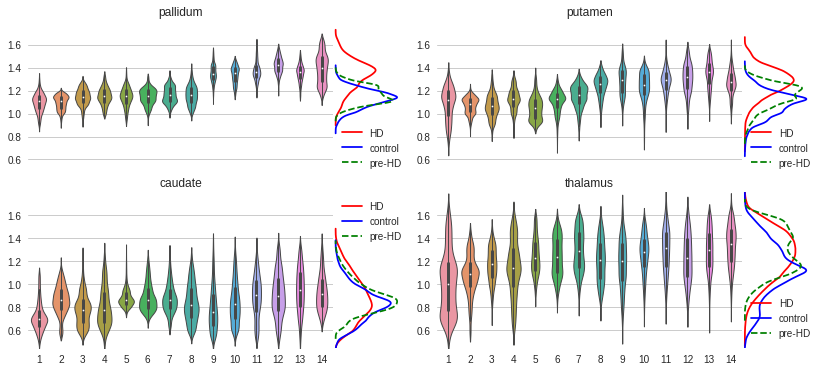

In [10]:
merged = masked_region_df_pbr.merge(pca_results[['group', 'subject_id', 'first_feature']], on='subject_id')
merged.sort_values(by='first_feature', inplace=True)
merged.reset_index(drop=True, inplace=True)

regions = ['pallidum', 'putamen', 'caudate', 'thalamus']
region_data = list(map(lambda r: merged[merged['region'] == r], regions))

def plot_roi_histograms(data, ax, ax_hist):
    sns.violinplot(data=data, x="subject_id", y="value", bw=.2, 
                   scale='count', cut=1, linewidth=1, ax=ax)
    groups = data.groupby('group')
    for name, group in groups:
        sns.kdeplot(group['value'], vertical=True, ax=ax_hist,
                    label=name, color=subject_colors[name],
                    ls=('--' if name=='pre-HD' else '-'))

fig = plt.figure(figsize=(14, 6))

# gridspec inside gridspec
outer_grid = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1)

for i in range(4):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2,
            subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0, width_ratios=[9,2],)
    ax = plt.Subplot(fig, inner_grid[0])  

    ax_hist = plt.Subplot(fig, inner_grid[1])
    plot_roi_histograms(region_data[i], ax, ax_hist)
    ax.set_title(regions[i])
    ax.set(ylim=(masked_region_df_pbr['value'].min(), masked_region_df_pbr['value'].max()))
    ax_hist.set(ylim=(masked_region_df_pbr['value'].min(), masked_region_df_pbr['value'].max()))

    ax.set_yticks([0.6, 0.8, 1, 1.2, 1.4, 1.6])
    # show only xticklabels only for the lower plots and show the patient number instead of subject_id
    if i in [0,1]:
        ax.set_xticks([])
    else:
        ax.set_xticklabels(list(range(1, len(merged)+1)))
    ax_hist.set_xticks([])
    ax_hist.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    fig.add_subplot(ax)
    fig.add_subplot(ax_hist)

all_axes = fig.get_axes()

#show only the outside spines
for ax in all_axes:
    for sp in ax.spines.values():
        sp.set_visible(False)
        
plt.savefig('results/figs/regions_of_interest_pbr.pdf', format='pdf')  

We can assess the difference between the distributions above using a permutation test. We compare the distributions for the control and HD for each region using the mean and the median of each subject as input.

In [11]:
def bipartition_means_difference(seq, size_l, size_r):
    '''
    Calculate the difference between the averages of a sequence bipartition
    
    Parameters
    ==========
    seq: numpy array like object
    size_l: int size of the left part
    size_r: int size of the right part
    '''
    if len(seq) != size_l + size_r:
        raise Exception('Not a bipartition')
        
    np.random.shuffle(seq)
    left = seq[:size_l]
    right = seq[-size_r:]
    return (left.mean() - right.mean())

def permutatation_test(z, y, num_samples):
    '''
    Calculate the p-value for a permutation test with num_samples
    
    Parameters
    ==========
    z: numpy array like object with one group of observations
    y: numpy array like object with another group of observations
    num_samples: int with the number of samples 
    '''
    pooled = np.hstack([z,y])
    delta = z.mean() - y.mean()
    
    estimates = map(lambda x: bipartition_means_difference(pooled, z.size, y.size), 
                    range(num_samples))
    count = len(list(filter(lambda x: x > delta, estimates)))
    
    return 1.0 - float(count)/float(num_samples)

num_samples = 100000

for stat in ['median', 'mean']:
        
    print('Permutations test p-values using the {0} as input'.format(stat))

    for region in regions:
        controls = np.array(masked_region_features_pbr['value'][stat][region][:3])
        hd = np.array(masked_region_features_pbr['value'][stat][region][4:])

        print (region, permutatation_test(controls, hd, num_samples))

Permutations test p-values using the median as input
pallidum 0.059840000000000004
putamen 0.007380000000000053
caudate 0.44693000000000005
thalamus 0.34918000000000005
Permutations test p-values using the mean as input
pallidum 0.05657000000000001
putamen 0.007469999999999977
caudate 0.43142
thalamus 0.41998


### Correlation between caudate volumes and inflammation

The volume of each region as it has a lot of variability, even among subjects with similar disease progression. We normalize the volumes and show the correlations between the value of the classifier for inflammation

In [12]:
region_volumes = masked_region_df_pbr.groupby(['subject_id', 'region']).agg('count').unstack()
# Pretty ugly fix: no time to do something smarter
region_volumes.columns = [' '.join(col).strip().split(' ')[1] for col in region_volumes.columns.values]

intracraneal_volume_df = participants_df[['subject_id', 'intracraneal_volume']].set_index('subject_id')

merged = region_volumes.join(intracraneal_volume_df)
merged = merged.div(merged.intracraneal_volume, axis='index')

normalized_region_volumes = hd_classifier.normalize(merged)
normalized_region_volumes.drop('intracraneal_volume', axis=1, inplace=True)

to_fit = normalized_region_volumes.join(pca_results[['first_feature', 'subject_id', 'group']].set_index('subject_id'))
to_fit

,caudate,pallidum,putamen,thalamus,first_feature,group
subject_id,,,,,,
sub-control06,1.133108,0.810849,0.767162,2.168097,-1.761875,control
sub-control04,1.013271,1.031377,1.317388,1.890655,-1.282251,control
sub-control01,0.470059,0.621381,0.045859,-0.590825,-1.041683,control
sub-control05,0.494861,0.885540,0.179945,1.253160,-0.750422,control
sub-control02,1.711536,1.060078,1.403697,-0.123007,-0.528717,control
sub-control03,0.760147,1.232750,0.853340,-0.210560,-0.514645,control
sub-patient01,0.040897,0.595554,1.183144,-0.158557,-0.117564,pre-HD
sub-patient02,0.235659,-0.193724,0.239201,-0.571727,-0.113103,HD
sub-patient04,-1.026189,-1.544380,-1.272116,-0.325858,0.501968,HD


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     28.38
Date:                Thu, 15 Feb 2018   Prob (F-statistic):           0.000180
Time:                        22:05:25   Log-Likelihood:                -10.852
No. Observations:                  14   AIC:                             25.70
Df Residuals:                      12   BIC:                             26.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.551e-17      0.152  -3.66e-16

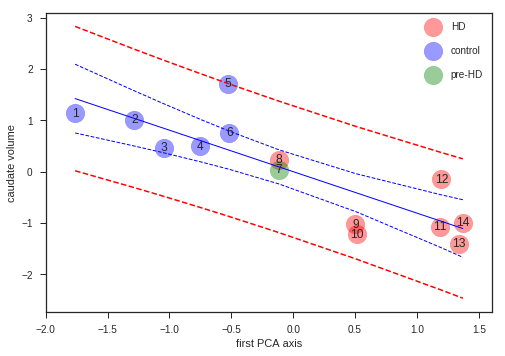

In [13]:
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm

sns.set_style("ticks")

def fit_region_volume_vs_score(to_fit, region):

    x = to_fit.first_feature
    y = to_fit[region].values
    X = sm.add_constant(x)

    return (x, y, sm.OLS(y, X).fit())

x, y, re = fit_region_volume_vs_score(to_fit, 'caudate')
print(re.summary())

st, data, ss2 = summary_table(re, alpha=0.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

plt.plot(x, fittedvalues, 'b-', lw=1)
plt.plot(x, predict_ci_low, 'r--', lw=1.5)
plt.plot(x, predict_ci_upp, 'r--', lw=1.5)
plt.plot(x, predict_mean_ci_low, 'b--', lw=1)
plt.plot(x, predict_mean_ci_upp, 'b--', lw=1)

groups = to_fit.groupby('group')

for name, items in groups:
    plt.scatter(items.first_feature, items.caudate, s=marker_size, alpha=0.4, 
               c=subject_colors[name], label=name)

for idx in range(len(to_fit)):
    plt.text(x[idx], y[idx], str(idx+1), 
            horizontalalignment='center', verticalalignment='center')

plt.xlabel('first PCA axis')
plt.ylabel('caudate volume')
plt.legend(labelspacing=1.4)
plt.savefig('results/figs/region_volumes_vs_inflammation_scores.pdf', format='pdf') 

#### Calculate the results of the regression for the other regions

In [14]:
for region in ['pallidum', 'putamen', 'thalamus']:
    _, _, re = fit_region_volume_vs_score(to_fit, region)
    print('Correlation between ' + region + ' volume and first PC')
    print(re.summary())
    print('+' * 91)

Correlation between pallidum volume and first PC
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     21.10
Date:                Thu, 15 Feb 2018   Prob (F-statistic):           0.000618
Time:                        22:05:25   Log-Likelihood:                -12.244
No. Observations:                  14   AIC:                             28.49
Df Residuals:                      12   BIC:                             29.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


### Thalamic nuclei analysis

Get the images in MNI space, instead of subject space, so we can use the atlas, and then apply all the masks in the atlas to each of the subject's MNI images. The result is a dictionary `masked_imgs` with the masked images for each nuclei and patient.

As the license of the Morel atlas does not allow redistribution, you need to get a [licensed copy of the Morel atlas](http://www.lead-dbs.org/?page_id=45) before using the code below to generate the plots yourself. 

In [15]:
from functools import reduce
from nilearn.image import resample_to_img, new_img_like
from nilearn.masking import apply_mask

def merge_nuclei_masks(nuclei, nuclei_masks, imgs):

    masks_to_join = []
    for k in nuclei:
        resampled = resample_to_img(nuclei_masks[k], imgs[0])        
        masks_to_join.append(resampled.get_data() > 0.5)

    joint_mask_data_as_bool = reduce(np.logical_or, masks_to_join) 
    joint_mask_as_bool = new_img_like(imgs[0], joint_mask_data_as_bool)
    masked_nuclei = apply_mask(imgs, joint_mask_as_bool)
    return masked_nuclei

def find_threshold(imgs, q):
    from math import floor
    parts = []
    for img in imgs:
        threshold_index = floor(q * len(img))
        parts.append(np.partition(img, threshold_index)[threshold_index:])
    merged = np.concatenate(parts)
    merged_threshold = floor (1- len(merged) / len(parts))
    return np.partition(merged, merged_threshold)[merged_threshold]

def make_masked_nuclei_imgs(imgs, path_to_morel_atlas, excludes):
    
    if not os.path.isdir(path_to_morel_atlas):
        raise FileNotFoundError
    
    left_volumes = glob.glob(os.path.join(path_to_morel_atlas, 'left-vols-1mm/*.nii.gz'))
    right_volumes = glob.glob(os.path.join(path_to_morel_atlas,'right-vols-1mm/*.nii.gz'))

    def parse_nuclei_name(vol):
        return os.path.dirname(vol).split('/')[-1].split('-')[0] + '_' + os.path.basename(vol).split('.')[0]

    nuclei_mask_dict = { parse_nuclei_name(vol) : vol 
                         for vol in left_volumes + right_volumes 
                         if not ''.join(parse_nuclei_name(vol).split('_')[1:]).startswith(tuple(excludes)) }

    nuclei_masks = { k: nib.load(v) for k, v in nuclei_mask_dict.items() }
    masked_img = {}
    nuclei_sizes = {}

    for k, v in nuclei_masks.items():
        resampled = resample_to_img(v, imgs[0])
        resampled_data_as_bool = resampled.get_data() > 0.5
        nuclei_sizes[k] = np.sum(resampled_data_as_bool)
        resampled_as_bool = new_img_like(resampled, resampled_data_as_bool)
        try: 
            masked_img[k] = apply_mask(imgs, resampled_as_bool)
        except:
            print('Something is wrong for nucleus {}, but I can keep going for the rest.'.format(k))
            continue
            
    return masked_img, nuclei_masks, nuclei_sizes

path_to_tracer_data = './data/func'
items = os.listdir(path_to_tracer_data)

subjects = hd_classifier.make_subjects(items, path_to_tracer_data)
mni_image_filter = 'nl_MNI152_norm_sm6mm.nii'

subjects.sort(key=lambda s: pca_results[pca_results['subject_id']==s.subject_id].index.tolist()[0])

assert ([s.subject_id for s in subjects] == list(pca_results['subject_id']))

mni_images = map(lambda s: hd_classifier.find_masks(s.images, mni_image_filter), subjects)
imgs = [nib.load(image) for image in list(itertools.chain.from_iterable(mni_images))]

path_to_morel_atlas = './data/private/Atlas/Morel'

try:
    excluded_nuclei = [] # = ['global', 'MAX']
    masked_img, nuclei_masks, nuclei_sizes = make_masked_nuclei_imgs(imgs, path_to_morel_atlas, excluded_nuclei)
except FileNotFoundError:
    print("You need a copy of the Morel Atlas")

Something is wrong for nucleus left_AD, but I can keep going for the rest.
Something is wrong for nucleus left_Pv, but I can keep going for the rest.
Something is wrong for nucleus right_AD, but I can keep going for the rest.


Plot the histogram of uptake for each relevant nuclei and subject. For the remaining nuclei in the Morel Atlas differences between controls and patients are not as marked as for those selected. The vertical lines are a guide ot the eye and mark the value of SUVR corresponding to the 95 percentile of all voxels in the control group.

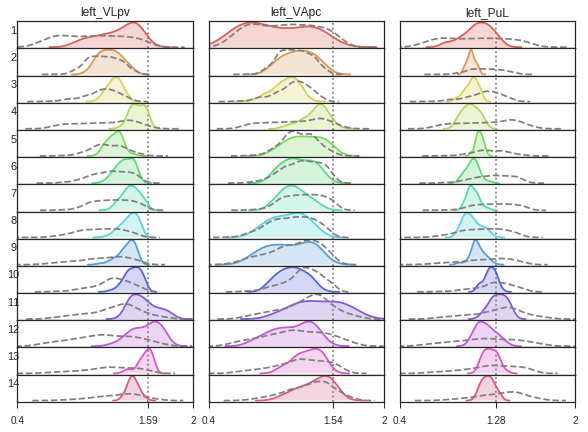

In [16]:
relevant_nuclei_group_names = ['left_VLpv', 'left_VApc', 'left_PuL']
relevant_nuclei_groups = { k: [it for it in list(nuclei_masks.keys()) if k in it] for k in relevant_nuclei_group_names }
masked_relevant_groups = {k: merge_nuclei_masks(v, nuclei_masks, imgs) for k, v in relevant_nuclei_groups.items()}

fig = plt.figure(figsize=(10, 7))
num_subjects = len(subjects)

# gridspec two split all patients and averages
outer_grid = gridspec.GridSpec(1, len(masked_relevant_groups), wspace=0.09, hspace=0)

min_x, max_x = 0.4, 2
pallete = sns.color_palette("hls", num_subjects)
grey_shadow = '#857e7e'

for j, (k, v) in enumerate(masked_relevant_groups.items()):   

    column_grid = gridspec.GridSpecFromSubplotSpec(num_subjects, 1,
                subplot_spec=outer_grid[j], wspace=0, hspace=0.0)

    for i in range(0, num_subjects):
        
        threshold = find_threshold(masked_img[k][:6], 0.90)
        
        ax = plt.Subplot(fig, column_grid[i])  
        ax.set(xlim=(min_x, max_x))
        if i == 0: ax.set_title(k)
        if i == num_subjects - 1:
            ax.set_xticks([min_x, threshold, max_x])
            ax.set_xticklabels([min_x, round(threshold, 2), max_x])
        else:
            ax.set_xticks([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xlabel('')
        if j == 0: 
            ax.set_ylabel(str(i+1), rotation='horizontal')
            
        ax.axvline(x=threshold, color=grey_shadow, ls=':')
        sns.kdeplot(v[i], shade=True, color=pallete[i], # use the same colors as before to identify subjects
                    ax=ax)
        #if 'left_PuL' in k:
        #    sns.kdeplot(masked_img['right_PuL'][i], shade=True, color=grey_shadow, ax=ax)
        sns.kdeplot(masked_img['left_global'][i], ls='--', ax=ax, color=grey_shadow)        
        
        fig.add_subplot(ax)      

plt.savefig('results/figs/nuclei.pdf', format='pdf')  